In [1]:
import os
os.chdir('../')

In [2]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F

import tqdm
tqdm.tqdm.pandas()

In [4]:
from rgnn_at_scale.data import prep_graph, split
from rgnn_at_scale.attacks import create_attack
from rgnn_at_scale.models import GCN
from rgnn_at_scale.train import train
from rgnn_at_scale.helper.utils import accuracy

## Config
**General config:**

In [5]:
datasets = ['cora_ml', 'citeseer', 'pubmed', 'ogbn-arxiv']
search_space_sizes = [1_000_000, 1_000_000, 2_500_000, 10_000_000]
binary_attr = False
attack = 'PRBCD'
seed = 0
device = 0
victim_param_list = [
    {
        'n_filters': 64,
        'dropout': 0.5
    },
    {
        'n_filters': 64,
        'dropout': 0.5
    },
    {
        'n_filters': 64,
        'dropout': 0.5
    },
    {
        'n_filters': [256, 256],
        'dropout': 0.5,
        'with_batchnorm': True,
    }
]
train_params = {
    'lr': 1e-2,
    'weight_decay': 0,
    'patience': 300,
    'max_epochs': 3000
}
attack_params = {
    'keep_heuristic': 'WeightOnly',
    'loss_type': 'tanhMargin',
    'fine_tune_epochs': 0,
    'with_early_stropping': False
}
epsilons = [0.001, 0.01, 0.1]
display_steps = 10

y_kde_max = 7.5

make_undirected_options = [True, False]
loss_types = ['CE', 'CW', 'tanhMargin']

torch.manual_seed(seed)
np.random.seed(seed)

**Config for plotting:**

In [6]:
bins = 6

assert bins % 2 == 0, 'Only an even number of bins supported'

x_0 = 4
x_1 = 2
x_2 = 0

bar_width = 0.8

neg_colormap = plt.get_cmap('Oranges')
pos_colormap = plt.get_cmap('Blues')

colors = (
    [neg_colormap((bins / 2 - i) / bins) for i in range(bins // 2)]
    + [pos_colormap((bins / 2 - i) / bins) for i in reversed(range(bins // 2))]
)

fig_width = 0.35
fig_ratio_yx = 0.6

## Attack and Generate Plots

cora_ml 1000000 {'n_filters': 64, 'dropout': 0.5} False


Training...:   0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 2/400 [00:00<00:24, 16.15it/s]

Clean accuracy: 0.64861661195755
cora_ml False 0.001 CE

Before the attack - Loss: 1.0757850408554077 Accuracy: 64.862 %


Epoch: 0 Loss: 1.0757807493209839 Accuracy: 64.664 %



  6%|▌         | 24/400 [00:01<00:20, 18.50it/s]


Epoch: 20 Loss: 1.0968644618988037 Accuracy: 64.862 %



 11%|█         | 44/400 [00:02<00:19, 18.51it/s]


Epoch: 40 Loss: 1.0991705656051636 Accuracy: 64.862 %



 16%|█▌        | 64/400 [00:03<00:18, 18.52it/s]


Epoch: 60 Loss: 1.1001869440078735 Accuracy: 64.862 %



 21%|██        | 84/400 [00:04<00:17, 18.48it/s]


Epoch: 80 Loss: 1.1008151769638062 Accuracy: 64.862 %



 26%|██▌       | 104/400 [00:05<00:15, 18.55it/s]


Epoch: 100 Loss: 1.101261019706726 Accuracy: 64.862 %



 31%|███       | 124/400 [00:06<00:15, 18.27it/s]


Epoch: 120 Loss: 1.1016108989715576 Accuracy: 64.862 %



 36%|███▌      | 144/400 [00:07<00:13, 18.56it/s]


Epoch: 140 Loss: 1.1018859148025513 Accuracy: 64.862 %



 41%|████      | 164/400 [00:08<00:12, 18.55it/s]


Epoch: 160 Loss: 1.1021229028701782 Accuracy: 64.862 %



 46%|████▌     | 184/400 [00:09<00:11, 18.55it/s]


Epoch: 180 Loss: 1.1023218631744385 Accuracy: 64.862 %



 51%|█████     | 204/400 [00:11<00:10, 18.50it/s]


Epoch: 200 Loss: 1.1024670600891113 Accuracy: 64.862 %



 56%|█████▌    | 224/400 [00:12<00:09, 18.50it/s]


Epoch: 220 Loss: 1.1025961637496948 Accuracy: 64.862 %



 61%|██████    | 244/400 [00:13<00:08, 18.60it/s]


Epoch: 240 Loss: 1.1026935577392578 Accuracy: 64.862 %



 66%|██████▌   | 264/400 [00:14<00:07, 18.52it/s]


Epoch: 260 Loss: 1.1027884483337402 Accuracy: 64.862 %



 71%|███████   | 284/400 [00:15<00:06, 18.57it/s]


Epoch: 280 Loss: 1.1028757095336914 Accuracy: 64.862 %



 76%|███████▌  | 304/400 [00:16<00:05, 18.50it/s]


Epoch: 300 Loss: 1.102955937385559 Accuracy: 64.862 %



 81%|████████  | 324/400 [00:17<00:04, 18.39it/s]


Epoch: 320 Loss: 1.103026032447815 Accuracy: 64.862 %



 86%|████████▌ | 344/400 [00:18<00:03, 18.53it/s]


Epoch: 340 Loss: 1.1030893325805664 Accuracy: 64.862 %



 91%|█████████ | 364/400 [00:19<00:01, 18.60it/s]


Epoch: 360 Loss: 1.1031455993652344 Accuracy: 64.862 %



 96%|█████████▌| 384/400 [00:20<00:00, 18.54it/s]


Epoch: 380 Loss: 1.1031917333602905 Accuracy: 64.862 %



  0%|          | 0/400 [00:00<?, ?it/s]

Perturbed accuracy: 0.6482213139533997
cora_ml False 0.001 CW

Before the attack - Loss: -2.0415761470794678 Accuracy: 64.862 %



  1%|          | 4/400 [00:00<00:21, 18.19it/s]


Epoch: 0 Loss: -2.041541337966919 Accuracy: 64.901 %



  6%|▌         | 24/400 [00:01<00:20, 18.23it/s]


Epoch: 20 Loss: -1.9930003881454468 Accuracy: 64.862 %



 11%|█         | 44/400 [00:02<00:19, 18.21it/s]


Epoch: 40 Loss: -1.9921762943267822 Accuracy: 64.862 %



 16%|█▌        | 64/400 [00:03<00:18, 18.11it/s]


Epoch: 60 Loss: -1.9917794466018677 Accuracy: 64.862 %



 21%|██        | 84/400 [00:04<00:17, 18.14it/s]


Epoch: 80 Loss: -1.9915640354156494 Accuracy: 64.862 %



 26%|██▌       | 104/400 [00:05<00:16, 18.18it/s]


Epoch: 100 Loss: -1.9913928508758545 Accuracy: 64.862 %



 31%|███       | 124/400 [00:06<00:15, 18.13it/s]


Epoch: 120 Loss: -1.991247534751892 Accuracy: 64.862 %



 36%|███▌      | 144/400 [00:07<00:14, 18.21it/s]


Epoch: 140 Loss: -1.9912128448486328 Accuracy: 64.862 %



 41%|████      | 164/400 [00:09<00:13, 18.12it/s]


Epoch: 160 Loss: -1.991163969039917 Accuracy: 64.862 %



 46%|████▌     | 184/400 [00:10<00:11, 18.18it/s]


Epoch: 180 Loss: -1.9910407066345215 Accuracy: 64.862 %



 51%|█████     | 204/400 [00:11<00:10, 18.15it/s]


Epoch: 200 Loss: -1.9909625053405762 Accuracy: 64.862 %



 56%|█████▌    | 224/400 [00:12<00:09, 18.14it/s]


Epoch: 220 Loss: -1.9909603595733643 Accuracy: 64.862 %



 61%|██████    | 244/400 [00:13<00:08, 18.21it/s]


Epoch: 240 Loss: -1.990884780883789 Accuracy: 64.862 %



 66%|██████▌   | 264/400 [00:14<00:07, 18.06it/s]


Epoch: 260 Loss: -1.9908164739608765 Accuracy: 64.862 %



 71%|███████   | 284/400 [00:15<00:06, 18.15it/s]


Epoch: 280 Loss: -1.9908230304718018 Accuracy: 64.862 %



 76%|███████▌  | 304/400 [00:16<00:05, 18.14it/s]


Epoch: 300 Loss: -1.9907255172729492 Accuracy: 64.862 %



 81%|████████  | 324/400 [00:17<00:04, 18.11it/s]


Epoch: 320 Loss: -1.9907183647155762 Accuracy: 64.862 %



 86%|████████▌ | 344/400 [00:18<00:03, 18.07it/s]


Epoch: 340 Loss: -1.9906967878341675 Accuracy: 64.862 %



 91%|█████████ | 364/400 [00:20<00:01, 18.05it/s]


Epoch: 360 Loss: -1.9906816482543945 Accuracy: 64.862 %



 96%|█████████▌| 384/400 [00:21<00:00, 18.17it/s]


Epoch: 380 Loss: -1.9906373023986816 Accuracy: 64.862 %



  0%|          | 0/400 [00:00<?, ?it/s]

Perturbed accuracy: 0.6458497643470764
cora_ml False 0.001 tanhMargin

Before the attack - Loss: -0.29617342352867126 Accuracy: 64.862 %



  1%|          | 4/400 [00:00<00:21, 18.15it/s]


Epoch: 0 Loss: -0.2961744964122772 Accuracy: 64.190 %



  6%|▌         | 24/400 [00:01<00:20, 18.22it/s]


Epoch: 20 Loss: -0.27606838941574097 Accuracy: 62.451 %



 11%|█         | 44/400 [00:02<00:19, 18.16it/s]


Epoch: 40 Loss: -0.2743612825870514 Accuracy: 62.174 %



 16%|█▌        | 64/400 [00:03<00:18, 18.19it/s]


Epoch: 60 Loss: -0.27368223667144775 Accuracy: 61.897 %



 21%|██        | 84/400 [00:04<00:17, 18.09it/s]


Epoch: 80 Loss: -0.27329304814338684 Accuracy: 61.937 %



 26%|██▌       | 104/400 [00:05<00:16, 18.12it/s]


Epoch: 100 Loss: -0.27304187417030334 Accuracy: 61.937 %



 31%|███       | 124/400 [00:06<00:15, 18.02it/s]


Epoch: 120 Loss: -0.2728622555732727 Accuracy: 61.976 %



 36%|███▌      | 144/400 [00:07<00:14, 18.19it/s]


Epoch: 140 Loss: -0.272726833820343 Accuracy: 61.858 %



 41%|████      | 164/400 [00:09<00:13, 18.15it/s]


Epoch: 160 Loss: -0.2726439833641052 Accuracy: 61.858 %



 46%|████▌     | 184/400 [00:10<00:11, 18.15it/s]


Epoch: 180 Loss: -0.2725543975830078 Accuracy: 61.897 %



 51%|█████     | 204/400 [00:11<00:10, 18.22it/s]


Epoch: 200 Loss: -0.2725101113319397 Accuracy: 61.818 %



 56%|█████▌    | 224/400 [00:12<00:09, 18.06it/s]


Epoch: 220 Loss: -0.2724530100822449 Accuracy: 61.818 %



 61%|██████    | 244/400 [00:13<00:08, 18.13it/s]


Epoch: 240 Loss: -0.2724006772041321 Accuracy: 61.858 %



 66%|██████▌   | 264/400 [00:14<00:07, 18.04it/s]


Epoch: 260 Loss: -0.2723640501499176 Accuracy: 61.858 %



 71%|███████   | 284/400 [00:15<00:06, 18.11it/s]


Epoch: 280 Loss: -0.272329181432724 Accuracy: 61.818 %



 76%|███████▌  | 304/400 [00:16<00:05, 18.06it/s]


Epoch: 300 Loss: -0.2723102867603302 Accuracy: 61.818 %



 81%|████████  | 324/400 [00:17<00:04, 18.13it/s]


Epoch: 320 Loss: -0.2722896933555603 Accuracy: 61.818 %



 86%|████████▌ | 344/400 [00:18<00:03, 18.06it/s]


Epoch: 340 Loss: -0.27225637435913086 Accuracy: 61.818 %



 91%|█████████ | 364/400 [00:20<00:01, 18.19it/s]


Epoch: 360 Loss: -0.27224838733673096 Accuracy: 61.818 %



 96%|█████████▌| 384/400 [00:21<00:00, 18.22it/s]


Epoch: 380 Loss: -0.2722267806529999 Accuracy: 61.858 %



100%|██████████| 400/400 [00:22<00:00, 18.15it/s]


Perturbed accuracy: 0.6454545259475708


  0%|          | 2/400 [00:00<00:20, 19.39it/s]

cora_ml False 0.01 CE

Before the attack - Loss: 1.0757850408554077 Accuracy: 64.862 %


Epoch: 0 Loss: 1.0757807493209839 Accuracy: 63.162 %



  6%|▌         | 24/400 [00:01<00:19, 19.56it/s]


Epoch: 20 Loss: 1.2689013481140137 Accuracy: 64.822 %



 11%|█         | 44/400 [00:02<00:18, 19.48it/s]


Epoch: 40 Loss: 1.278224229812622 Accuracy: 64.822 %



 16%|█▌        | 64/400 [00:03<00:17, 19.45it/s]


Epoch: 60 Loss: 1.2820888757705688 Accuracy: 64.862 %



 21%|██        | 84/400 [00:04<00:16, 19.46it/s]


Epoch: 80 Loss: 1.2843961715698242 Accuracy: 64.862 %



 26%|██▌       | 104/400 [00:05<00:15, 19.40it/s]


Epoch: 100 Loss: 1.285829782485962 Accuracy: 64.862 %



 31%|███       | 124/400 [00:06<00:14, 19.37it/s]


Epoch: 120 Loss: 1.2868317365646362 Accuracy: 64.862 %



 36%|███▌      | 144/400 [00:07<00:13, 19.45it/s]


Epoch: 140 Loss: 1.2876108884811401 Accuracy: 64.862 %



 41%|████      | 164/400 [00:08<00:12, 19.42it/s]


Epoch: 160 Loss: 1.2882301807403564 Accuracy: 64.862 %



 46%|████▌     | 184/400 [00:09<00:11, 19.42it/s]


Epoch: 180 Loss: 1.2887648344039917 Accuracy: 64.862 %



 51%|█████     | 204/400 [00:10<00:10, 19.41it/s]


Epoch: 200 Loss: 1.2892155647277832 Accuracy: 64.862 %



 56%|█████▌    | 224/400 [00:11<00:09, 19.34it/s]


Epoch: 220 Loss: 1.2895721197128296 Accuracy: 64.862 %



 61%|██████    | 244/400 [00:12<00:08, 19.44it/s]


Epoch: 240 Loss: 1.2899593114852905 Accuracy: 64.862 %



 66%|██████▌   | 264/400 [00:13<00:07, 19.30it/s]


Epoch: 260 Loss: 1.2902394533157349 Accuracy: 64.862 %



 71%|███████   | 284/400 [00:14<00:06, 19.29it/s]


Epoch: 280 Loss: 1.290444254875183 Accuracy: 64.862 %



 76%|███████▌  | 304/400 [00:15<00:04, 19.40it/s]


Epoch: 300 Loss: 1.2906368970870972 Accuracy: 64.862 %



 81%|████████  | 324/400 [00:16<00:03, 19.40it/s]


Epoch: 320 Loss: 1.2908183336257935 Accuracy: 64.862 %



 86%|████████▌ | 344/400 [00:17<00:02, 19.40it/s]


Epoch: 340 Loss: 1.2909514904022217 Accuracy: 64.862 %



 91%|█████████ | 364/400 [00:18<00:01, 19.40it/s]


Epoch: 360 Loss: 1.2911068201065063 Accuracy: 64.862 %



 96%|█████████▌| 384/400 [00:19<00:00, 19.31it/s]


Epoch: 380 Loss: 1.2912217378616333 Accuracy: 64.862 %



  0%|          | 0/400 [00:00<?, ?it/s]

Perturbed accuracy: 0.6474308371543884
cora_ml False 0.01 CW

Before the attack - Loss: -2.0415761470794678 Accuracy: 64.862 %


Epoch: 0 Loss: -2.041541337966919 Accuracy: 63.874 %



  6%|▌         | 24/400 [00:01<00:19, 19.18it/s]


Epoch: 20 Loss: -1.7086511850357056 Accuracy: 64.664 %



 11%|█         | 44/400 [00:02<00:18, 19.22it/s]


Epoch: 40 Loss: -1.703222632408142 Accuracy: 64.743 %



 16%|█▌        | 64/400 [00:03<00:17, 19.18it/s]


Epoch: 60 Loss: -1.701074242591858 Accuracy: 64.625 %



 21%|██        | 84/400 [00:04<00:16, 19.23it/s]


Epoch: 80 Loss: -1.7001516819000244 Accuracy: 64.585 %



 26%|██▌       | 104/400 [00:05<00:15, 19.22it/s]


Epoch: 100 Loss: -1.6994295120239258 Accuracy: 64.585 %



 31%|███       | 124/400 [00:06<00:14, 19.19it/s]


Epoch: 120 Loss: -1.6990110874176025 Accuracy: 64.625 %



 36%|███▌      | 144/400 [00:07<00:13, 19.23it/s]


Epoch: 140 Loss: -1.6988801956176758 Accuracy: 64.664 %



 41%|████      | 164/400 [00:08<00:12, 19.23it/s]


Epoch: 160 Loss: -1.6985749006271362 Accuracy: 64.743 %



 46%|████▌     | 184/400 [00:09<00:11, 19.17it/s]


Epoch: 180 Loss: -1.69841468334198 Accuracy: 64.585 %



 51%|█████     | 204/400 [00:10<00:10, 19.12it/s]


Epoch: 200 Loss: -1.6984143257141113 Accuracy: 64.506 %



 56%|█████▌    | 224/400 [00:11<00:09, 19.05it/s]


Epoch: 220 Loss: -1.6982958316802979 Accuracy: 64.704 %



 61%|██████    | 244/400 [00:12<00:08, 18.93it/s]


Epoch: 240 Loss: -1.6981674432754517 Accuracy: 64.822 %



 66%|██████▌   | 264/400 [00:13<00:07, 17.79it/s]


Epoch: 260 Loss: -1.6981794834136963 Accuracy: 64.822 %



 71%|███████   | 284/400 [00:14<00:06, 16.86it/s]


Epoch: 280 Loss: -1.6979804039001465 Accuracy: 64.664 %



 76%|███████▌  | 304/400 [00:16<00:05, 16.79it/s]


Epoch: 300 Loss: -1.6981287002563477 Accuracy: 64.664 %



 81%|████████  | 324/400 [00:17<00:04, 16.77it/s]


Epoch: 320 Loss: -1.697916030883789 Accuracy: 64.704 %



 86%|████████▌ | 344/400 [00:18<00:03, 16.80it/s]


Epoch: 340 Loss: -1.6979700326919556 Accuracy: 64.664 %



 91%|█████████ | 364/400 [00:19<00:02, 16.59it/s]


Epoch: 360 Loss: -1.6979387998580933 Accuracy: 64.664 %



 96%|█████████▌| 384/400 [00:20<00:00, 17.05it/s]


Epoch: 380 Loss: -1.6979111433029175 Accuracy: 64.427 %



  0%|          | 0/400 [00:00<?, ?it/s]

Perturbed accuracy: 0.6272727251052856
cora_ml False 0.01 tanhMargin

Before the attack - Loss: -0.29617342352867126 Accuracy: 64.862 %



  1%|          | 4/400 [00:00<00:22, 17.92it/s]


Epoch: 0 Loss: -0.2961744964122772 Accuracy: 60.672 %



  6%|▌         | 24/400 [00:01<00:20, 17.92it/s]


Epoch: 20 Loss: -0.16555072367191315 Accuracy: 54.190 %



 11%|█         | 44/400 [00:02<00:19, 18.10it/s]


Epoch: 40 Loss: -0.1624295711517334 Accuracy: 54.111 %



 16%|█▌        | 64/400 [00:03<00:18, 18.15it/s]


Epoch: 60 Loss: -0.16145330667495728 Accuracy: 54.032 %



 21%|██        | 84/400 [00:04<00:17, 18.11it/s]


Epoch: 80 Loss: -0.16095946729183197 Accuracy: 53.953 %



 26%|██▌       | 104/400 [00:05<00:16, 17.79it/s]


Epoch: 100 Loss: -0.16066612303256989 Accuracy: 53.953 %



 31%|███       | 124/400 [00:06<00:15, 17.99it/s]


Epoch: 120 Loss: -0.16048112511634827 Accuracy: 53.913 %



 36%|███▌      | 144/400 [00:08<00:14, 17.85it/s]


Epoch: 140 Loss: -0.1603245884180069 Accuracy: 53.913 %



 41%|████      | 164/400 [00:09<00:13, 17.65it/s]


Epoch: 160 Loss: -0.1601976752281189 Accuracy: 53.913 %



 46%|████▌     | 184/400 [00:10<00:12, 17.94it/s]


Epoch: 180 Loss: -0.16016025841236115 Accuracy: 53.913 %



 51%|█████     | 204/400 [00:11<00:10, 18.18it/s]


Epoch: 200 Loss: -0.16009293496608734 Accuracy: 53.913 %



 56%|█████▌    | 224/400 [00:12<00:09, 18.16it/s]


Epoch: 220 Loss: -0.16003064811229706 Accuracy: 53.913 %



 61%|██████    | 244/400 [00:13<00:08, 18.16it/s]


Epoch: 240 Loss: -0.15995745360851288 Accuracy: 53.913 %



 66%|██████▌   | 264/400 [00:14<00:07, 18.21it/s]


Epoch: 260 Loss: -0.1599699854850769 Accuracy: 53.913 %



 71%|███████   | 284/400 [00:15<00:06, 17.97it/s]


Epoch: 280 Loss: -0.15992695093154907 Accuracy: 53.913 %



 76%|███████▌  | 304/400 [00:16<00:05, 18.07it/s]


Epoch: 300 Loss: -0.15991082787513733 Accuracy: 53.913 %



 81%|████████  | 324/400 [00:18<00:04, 17.72it/s]


Epoch: 320 Loss: -0.15990900993347168 Accuracy: 53.913 %



 86%|████████▌ | 344/400 [00:19<00:03, 17.95it/s]


Epoch: 340 Loss: -0.15987750887870789 Accuracy: 53.913 %



 91%|█████████ | 364/400 [00:20<00:02, 17.90it/s]


Epoch: 360 Loss: -0.1598254144191742 Accuracy: 53.913 %



 96%|█████████▌| 384/400 [00:21<00:00, 17.75it/s]


Epoch: 380 Loss: -0.15982666611671448 Accuracy: 53.913 %



  0%|          | 0/400 [00:00<?, ?it/s]

Perturbed accuracy: 0.6209486126899719
cora_ml False 0.1 CE

Before the attack - Loss: 1.0757850408554077 Accuracy: 64.862 %


Epoch: 0 Loss: 1.0757806301116943 Accuracy: 56.680 %



  6%|▌         | 24/400 [00:01<00:20, 18.59it/s]


Epoch: 20 Loss: 2.4701013565063477 Accuracy: 62.846 %



 11%|█         | 44/400 [00:02<00:19, 18.04it/s]


Epoch: 40 Loss: 2.506220579147339 Accuracy: 62.964 %



 16%|█▌        | 64/400 [00:03<00:18, 18.05it/s]


Epoch: 60 Loss: 2.5197222232818604 Accuracy: 62.964 %



 21%|██        | 84/400 [00:04<00:17, 18.09it/s]


Epoch: 80 Loss: 2.5265023708343506 Accuracy: 62.964 %



 26%|██▌       | 104/400 [00:05<00:16, 18.20it/s]


Epoch: 100 Loss: 2.5315887928009033 Accuracy: 62.964 %



 31%|███       | 124/400 [00:06<00:14, 18.40it/s]


Epoch: 120 Loss: 2.533433675765991 Accuracy: 63.004 %



 36%|███▌      | 144/400 [00:07<00:14, 18.26it/s]


Epoch: 140 Loss: 2.5347883701324463 Accuracy: 63.004 %



 41%|████      | 164/400 [00:08<00:12, 18.37it/s]


Epoch: 160 Loss: 2.535496473312378 Accuracy: 63.004 %



 46%|████▌     | 184/400 [00:10<00:11, 18.36it/s]


Epoch: 180 Loss: 2.5363805294036865 Accuracy: 63.004 %



 51%|█████     | 204/400 [00:11<00:10, 18.39it/s]


Epoch: 200 Loss: 2.5369014739990234 Accuracy: 63.083 %



 56%|█████▌    | 224/400 [00:12<00:10, 17.04it/s]


Epoch: 220 Loss: 2.5373449325561523 Accuracy: 63.123 %



 61%|██████    | 244/400 [00:13<00:09, 17.19it/s]


Epoch: 240 Loss: 2.53757381439209 Accuracy: 63.123 %



 66%|██████▌   | 264/400 [00:14<00:07, 17.70it/s]


Epoch: 260 Loss: 2.537883758544922 Accuracy: 63.123 %



 71%|███████   | 284/400 [00:15<00:06, 18.26it/s]


Epoch: 280 Loss: 2.538465738296509 Accuracy: 63.162 %



 76%|███████▌  | 304/400 [00:16<00:05, 18.25it/s]


Epoch: 300 Loss: 2.5387353897094727 Accuracy: 63.162 %



 81%|████████  | 324/400 [00:17<00:04, 18.25it/s]


Epoch: 320 Loss: 2.538743019104004 Accuracy: 63.162 %



 86%|████████▌ | 344/400 [00:18<00:03, 18.32it/s]


Epoch: 340 Loss: 2.5387940406799316 Accuracy: 63.162 %



 91%|█████████ | 364/400 [00:20<00:02, 17.82it/s]


Epoch: 360 Loss: 2.538883924484253 Accuracy: 63.162 %



 96%|█████████▌| 384/400 [00:21<00:00, 18.57it/s]


Epoch: 380 Loss: 2.5388858318328857 Accuracy: 63.162 %



100%|██████████| 400/400 [00:22<00:00, 18.12it/s]
<ipython-input-7-dbb500855ba6>:146: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
  0%|          | 0/400 [00:00<?, ?it/s]

Perturbed accuracy: 0.6288537383079529
cora_ml False 0.1 CW

Before the attack - Loss: -2.0415761470794678 Accuracy: 64.862 %



  1%|          | 4/400 [00:00<00:22, 17.90it/s]


Epoch: 0 Loss: -2.041541337966919 Accuracy: 59.960 %



  6%|▌         | 24/400 [00:01<00:20, 18.21it/s]


Epoch: 20 Loss: -0.7075756192207336 Accuracy: 50.751 %



 11%|█         | 44/400 [00:02<00:19, 17.88it/s]


Epoch: 40 Loss: -0.6819309592247009 Accuracy: 50.356 %



 16%|█▌        | 64/400 [00:03<00:18, 17.81it/s]


Epoch: 60 Loss: -0.6792263388633728 Accuracy: 50.040 %



 21%|██        | 84/400 [00:04<00:17, 17.60it/s]


Epoch: 80 Loss: -0.6703139543533325 Accuracy: 50.553 %



 26%|██▌       | 104/400 [00:05<00:16, 17.59it/s]


Epoch: 100 Loss: -0.6726709008216858 Accuracy: 50.632 %



 31%|███       | 124/400 [00:06<00:15, 17.48it/s]


Epoch: 120 Loss: -0.6951854228973389 Accuracy: 50.672 %



 36%|███▌      | 144/400 [00:08<00:14, 17.67it/s]


Epoch: 140 Loss: -0.6791992783546448 Accuracy: 50.632 %



 41%|████      | 164/400 [00:09<00:13, 17.60it/s]


Epoch: 160 Loss: -0.6689525246620178 Accuracy: 50.672 %



 46%|████▌     | 184/400 [00:10<00:12, 17.67it/s]


Epoch: 180 Loss: -0.6751939654350281 Accuracy: 50.553 %



 51%|█████     | 204/400 [00:11<00:11, 17.80it/s]


Epoch: 200 Loss: -0.6690200567245483 Accuracy: 51.067 %



 56%|█████▌    | 224/400 [00:12<00:09, 18.25it/s]


Epoch: 220 Loss: -0.6689549684524536 Accuracy: 50.356 %



 61%|██████    | 244/400 [00:13<00:08, 18.55it/s]


Epoch: 240 Loss: -0.6743931174278259 Accuracy: 49.605 %



 66%|██████▌   | 264/400 [00:14<00:07, 17.11it/s]


Epoch: 260 Loss: -0.6761690378189087 Accuracy: 50.040 %



 71%|███████   | 284/400 [00:15<00:06, 17.66it/s]


Epoch: 280 Loss: -0.6630075573921204 Accuracy: 50.593 %



 76%|███████▌  | 304/400 [00:17<00:05, 17.87it/s]


Epoch: 300 Loss: -0.6678100824356079 Accuracy: 50.395 %



 81%|████████  | 324/400 [00:18<00:04, 18.55it/s]


Epoch: 320 Loss: -0.6679600477218628 Accuracy: 50.000 %



 86%|████████▌ | 344/400 [00:19<00:03, 18.53it/s]


Epoch: 340 Loss: -0.6614173054695129 Accuracy: 50.040 %



 91%|█████████ | 364/400 [00:20<00:01, 18.09it/s]


Epoch: 360 Loss: -0.6693844795227051 Accuracy: 50.158 %



 96%|█████████▌| 384/400 [00:21<00:00, 18.10it/s]


Epoch: 380 Loss: -0.6676978468894958 Accuracy: 50.672 %



  0%|          | 0/400 [00:00<?, ?it/s]

Perturbed accuracy: 0.5146244764328003
cora_ml False 0.1 tanhMargin

Before the attack - Loss: -0.29617342352867126 Accuracy: 64.862 %


Epoch: 0 Loss: -0.2961744964122772 Accuracy: 51.621 %



  6%|▌         | 24/400 [00:01<00:21, 17.73it/s]


Epoch: 20 Loss: 0.19581030309200287 Accuracy: 36.245 %



 11%|█         | 44/400 [00:02<00:19, 18.62it/s]


Epoch: 40 Loss: 0.20593835413455963 Accuracy: 35.889 %



 16%|█▌        | 64/400 [00:03<00:18, 18.33it/s]


Epoch: 60 Loss: 0.20863232016563416 Accuracy: 35.771 %



 21%|██        | 84/400 [00:04<00:17, 18.55it/s]


Epoch: 80 Loss: 0.2109707146883011 Accuracy: 35.613 %



 26%|██▌       | 104/400 [00:05<00:16, 18.15it/s]


Epoch: 100 Loss: 0.21221165359020233 Accuracy: 35.573 %



 31%|███       | 124/400 [00:06<00:15, 18.18it/s]


Epoch: 120 Loss: 0.2129870504140854 Accuracy: 35.494 %



 36%|███▌      | 144/400 [00:07<00:14, 18.00it/s]


Epoch: 140 Loss: 0.21348711848258972 Accuracy: 35.494 %



 41%|████      | 164/400 [00:09<00:13, 18.00it/s]


Epoch: 160 Loss: 0.21369001269340515 Accuracy: 35.494 %



 46%|████▌     | 184/400 [00:10<00:11, 18.07it/s]


Epoch: 180 Loss: 0.21378475427627563 Accuracy: 35.494 %



 51%|█████     | 204/400 [00:11<00:10, 18.05it/s]


Epoch: 200 Loss: 0.2141566276550293 Accuracy: 35.455 %



 56%|█████▌    | 224/400 [00:12<00:09, 18.10it/s]


Epoch: 220 Loss: 0.21437177062034607 Accuracy: 35.455 %



 61%|██████    | 244/400 [00:13<00:08, 18.26it/s]


Epoch: 240 Loss: 0.2148667573928833 Accuracy: 35.415 %



 66%|██████▌   | 264/400 [00:14<00:07, 17.98it/s]


Epoch: 260 Loss: 0.21489231288433075 Accuracy: 35.375 %



 71%|███████   | 284/400 [00:15<00:06, 17.90it/s]


Epoch: 280 Loss: 0.21502019464969635 Accuracy: 35.375 %



 76%|███████▌  | 304/400 [00:16<00:05, 18.00it/s]


Epoch: 300 Loss: 0.21503394842147827 Accuracy: 35.375 %



 81%|████████  | 324/400 [00:17<00:04, 17.88it/s]


Epoch: 320 Loss: 0.215034618973732 Accuracy: 35.375 %



 86%|████████▌ | 344/400 [00:19<00:03, 17.93it/s]


Epoch: 340 Loss: 0.21560676395893097 Accuracy: 35.336 %



 91%|█████████ | 364/400 [00:20<00:01, 18.03it/s]


Epoch: 360 Loss: 0.21559664607048035 Accuracy: 35.336 %



 96%|█████████▌| 384/400 [00:21<00:00, 18.05it/s]


Epoch: 380 Loss: 0.21581165492534637 Accuracy: 35.336 %



100%|██████████| 400/400 [00:22<00:00, 18.08it/s]


Perturbed accuracy: 0.4687747061252594
cora_ml 1000000 {'n_filters': 64, 'dropout': 0.5, 'row_norm': True} True


Training...:   0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 1/400 [00:00<00:43,  9.26it/s]

Clean accuracy: 0.7940711379051208
cora_ml True 0.001 CE

Before the attack - Loss: 0.7091850638389587 Accuracy: 79.407 %


Epoch: 0 Loss: 0.709175169467926 Accuracy: 78.893 %



  6%|▌         | 22/400 [00:02<00:40,  9.31it/s]


Epoch: 20 Loss: 0.7459877729415894 Accuracy: 79.091 %



 10%|█         | 42/400 [00:04<00:38,  9.30it/s]


Epoch: 40 Loss: 0.7483177185058594 Accuracy: 79.051 %



 16%|█▌        | 62/400 [00:06<00:36,  9.17it/s]


Epoch: 60 Loss: 0.7494080066680908 Accuracy: 79.051 %



 20%|██        | 82/400 [00:08<00:34,  9.14it/s]


Epoch: 80 Loss: 0.7501153349876404 Accuracy: 79.091 %



 26%|██▌       | 102/400 [00:11<00:32,  9.12it/s]


Epoch: 100 Loss: 0.7505803108215332 Accuracy: 79.091 %



 30%|███       | 122/400 [00:13<00:30,  9.11it/s]


Epoch: 120 Loss: 0.7509438395500183 Accuracy: 79.091 %



 36%|███▌      | 142/400 [00:15<00:28,  9.13it/s]


Epoch: 140 Loss: 0.7512341141700745 Accuracy: 79.051 %



 40%|████      | 162/400 [00:17<00:26,  9.14it/s]


Epoch: 160 Loss: 0.7514919638633728 Accuracy: 79.051 %



 46%|████▌     | 182/400 [00:19<00:24,  9.07it/s]


Epoch: 180 Loss: 0.7516853213310242 Accuracy: 79.051 %



 50%|█████     | 202/400 [00:22<00:21,  9.13it/s]


Epoch: 200 Loss: 0.751845121383667 Accuracy: 79.051 %



 56%|█████▌    | 222/400 [00:24<00:19,  9.12it/s]


Epoch: 220 Loss: 0.752001166343689 Accuracy: 79.051 %



 60%|██████    | 242/400 [00:26<00:17,  9.10it/s]


Epoch: 240 Loss: 0.7520991563796997 Accuracy: 79.051 %



 66%|██████▌   | 262/400 [00:28<00:15,  9.12it/s]


Epoch: 260 Loss: 0.7522284388542175 Accuracy: 79.051 %



 70%|███████   | 282/400 [00:30<00:12,  9.13it/s]


Epoch: 280 Loss: 0.7523292899131775 Accuracy: 79.051 %



 76%|███████▌  | 302/400 [00:32<00:10,  9.12it/s]


Epoch: 300 Loss: 0.752396821975708 Accuracy: 79.051 %



 80%|████████  | 322/400 [00:35<00:08,  9.13it/s]


Epoch: 320 Loss: 0.7524799108505249 Accuracy: 79.051 %



 86%|████████▌ | 342/400 [00:37<00:06,  9.10it/s]


Epoch: 340 Loss: 0.7525687217712402 Accuracy: 79.051 %



 90%|█████████ | 362/400 [00:39<00:04,  9.16it/s]


Epoch: 360 Loss: 0.752616822719574 Accuracy: 79.051 %



 96%|█████████▌| 382/400 [00:41<00:01,  9.11it/s]


Epoch: 380 Loss: 0.7526841163635254 Accuracy: 79.051 %



100%|██████████| 400/400 [00:43<00:00,  9.15it/s]


Perturbed accuracy: 0.791304349899292


  0%|          | 1/400 [00:00<00:43,  9.18it/s]

cora_ml True 0.001 CW

Before the attack - Loss: -4.36478328704834 Accuracy: 79.407 %


Epoch: 0 Loss: -4.364709377288818 Accuracy: 79.407 %



  6%|▌         | 22/400 [00:02<00:41,  9.10it/s]


Epoch: 20 Loss: -4.245095252990723 Accuracy: 79.407 %



 10%|█         | 42/400 [00:04<00:39,  9.06it/s]


Epoch: 40 Loss: -4.243067264556885 Accuracy: 79.407 %



 16%|█▌        | 62/400 [00:06<00:36,  9.19it/s]


Epoch: 60 Loss: -4.242120265960693 Accuracy: 79.407 %



 20%|██        | 82/400 [00:08<00:35,  9.06it/s]


Epoch: 80 Loss: -4.241715908050537 Accuracy: 79.407 %



 26%|██▌       | 102/400 [00:11<00:32,  9.05it/s]


Epoch: 100 Loss: -4.241405963897705 Accuracy: 79.407 %



 30%|███       | 122/400 [00:13<00:30,  9.01it/s]


Epoch: 120 Loss: -4.241005897521973 Accuracy: 79.407 %



 36%|███▌      | 142/400 [00:15<00:28,  9.01it/s]


Epoch: 140 Loss: -4.240799427032471 Accuracy: 79.407 %



 40%|████      | 162/400 [00:17<00:26,  9.00it/s]


Epoch: 160 Loss: -4.240789890289307 Accuracy: 79.407 %



 46%|████▌     | 182/400 [00:20<00:24,  9.03it/s]


Epoch: 180 Loss: -4.240553379058838 Accuracy: 79.407 %



 50%|█████     | 202/400 [00:22<00:21,  9.03it/s]


Epoch: 200 Loss: -4.240581512451172 Accuracy: 79.407 %



 56%|█████▌    | 222/400 [00:24<00:19,  9.04it/s]


Epoch: 220 Loss: -4.240405082702637 Accuracy: 79.407 %



 60%|██████    | 242/400 [00:26<00:17,  9.05it/s]


Epoch: 240 Loss: -4.24039888381958 Accuracy: 79.407 %



 66%|██████▌   | 262/400 [00:28<00:15,  9.04it/s]


Epoch: 260 Loss: -4.240328311920166 Accuracy: 79.407 %



 70%|███████   | 282/400 [00:31<00:13,  9.03it/s]


Epoch: 280 Loss: -4.240342617034912 Accuracy: 79.407 %



 76%|███████▌  | 302/400 [00:33<00:10,  9.04it/s]


Epoch: 300 Loss: -4.240274429321289 Accuracy: 79.407 %



 80%|████████  | 322/400 [00:35<00:08,  9.05it/s]


Epoch: 320 Loss: -4.240170001983643 Accuracy: 79.407 %



 86%|████████▌ | 342/400 [00:37<00:06,  9.04it/s]


Epoch: 340 Loss: -4.240140914916992 Accuracy: 79.407 %



 90%|█████████ | 362/400 [00:39<00:04,  9.04it/s]


Epoch: 360 Loss: -4.240113258361816 Accuracy: 79.407 %



 96%|█████████▌| 382/400 [00:42<00:01,  9.04it/s]


Epoch: 380 Loss: -4.240113735198975 Accuracy: 79.407 %



  0%|          | 0/400 [00:00<?, ?it/s]

Perturbed accuracy: 0.7916995882987976
cora_ml True 0.001 tanhMargin

Before the attack - Loss: -0.5868443846702576 Accuracy: 79.407 %



  0%|          | 2/400 [00:00<00:43,  9.22it/s]


Epoch: 0 Loss: -0.5868448615074158 Accuracy: 78.379 %



  6%|▌         | 22/400 [00:02<00:40,  9.25it/s]


Epoch: 20 Loss: -0.5530611276626587 Accuracy: 76.798 %



 10%|█         | 42/400 [00:04<00:38,  9.24it/s]


Epoch: 40 Loss: -0.551774799823761 Accuracy: 76.759 %



 16%|█▌        | 62/400 [00:06<00:38,  8.79it/s]


Epoch: 60 Loss: -0.5512489676475525 Accuracy: 76.759 %



 20%|██        | 82/400 [00:09<00:36,  8.73it/s]


Epoch: 80 Loss: -0.5509254336357117 Accuracy: 76.719 %



 26%|██▌       | 102/400 [00:11<00:34,  8.73it/s]


Epoch: 100 Loss: -0.5506756901741028 Accuracy: 76.719 %



 30%|███       | 122/400 [00:13<00:31,  8.74it/s]


Epoch: 120 Loss: -0.550495445728302 Accuracy: 76.719 %



 36%|███▌      | 142/400 [00:15<00:29,  8.74it/s]


Epoch: 140 Loss: -0.550405740737915 Accuracy: 76.719 %



 40%|████      | 162/400 [00:18<00:27,  8.75it/s]


Epoch: 160 Loss: -0.550258219242096 Accuracy: 76.719 %



 46%|████▌     | 182/400 [00:20<00:24,  8.75it/s]


Epoch: 180 Loss: -0.5501689314842224 Accuracy: 76.719 %



 50%|█████     | 202/400 [00:22<00:22,  8.75it/s]


Epoch: 200 Loss: -0.5501034259796143 Accuracy: 76.719 %



 56%|█████▌    | 222/400 [00:25<00:20,  8.75it/s]


Epoch: 220 Loss: -0.5500248074531555 Accuracy: 76.719 %



 60%|██████    | 242/400 [00:27<00:18,  8.74it/s]


Epoch: 240 Loss: -0.5499882698059082 Accuracy: 76.719 %



 66%|██████▌   | 262/400 [00:29<00:15,  8.72it/s]


Epoch: 260 Loss: -0.5499295592308044 Accuracy: 76.719 %



 70%|███████   | 282/400 [00:31<00:13,  8.70it/s]


Epoch: 280 Loss: -0.5498819351196289 Accuracy: 76.719 %



 76%|███████▌  | 302/400 [00:34<00:11,  8.74it/s]


Epoch: 300 Loss: -0.549790620803833 Accuracy: 76.680 %



 80%|████████  | 322/400 [00:36<00:08,  8.74it/s]


Epoch: 320 Loss: -0.5497134923934937 Accuracy: 76.680 %



 86%|████████▌ | 342/400 [00:38<00:06,  8.74it/s]


Epoch: 340 Loss: -0.5496711134910583 Accuracy: 76.680 %



 90%|█████████ | 362/400 [00:41<00:04,  8.74it/s]


Epoch: 360 Loss: -0.5496257543563843 Accuracy: 76.680 %



 96%|█████████▌| 382/400 [00:43<00:02,  8.73it/s]


Epoch: 380 Loss: -0.5495892763137817 Accuracy: 76.680 %



  0%|          | 0/400 [00:00<?, ?it/s]

Perturbed accuracy: 0.7865612506866455
cora_ml True 0.01 CE

Before the attack - Loss: 0.7091850638389587 Accuracy: 79.407 %



  0%|          | 2/400 [00:00<00:43,  9.08it/s]


Epoch: 0 Loss: 0.7091748714447021 Accuracy: 76.759 %



  6%|▌         | 22/400 [00:02<00:41,  9.14it/s]


Epoch: 20 Loss: 0.9737635850906372 Accuracy: 76.364 %



 10%|█         | 42/400 [00:04<00:39,  9.13it/s]


Epoch: 40 Loss: 0.9817971587181091 Accuracy: 76.324 %



 16%|█▌        | 62/400 [00:06<00:37,  9.13it/s]


Epoch: 60 Loss: 0.9851338863372803 Accuracy: 76.324 %



 20%|██        | 82/400 [00:08<00:34,  9.10it/s]


Epoch: 80 Loss: 0.9873604774475098 Accuracy: 76.324 %



 26%|██▌       | 102/400 [00:11<00:32,  9.11it/s]


Epoch: 100 Loss: 0.989207923412323 Accuracy: 76.324 %



 30%|███       | 122/400 [00:13<00:30,  9.11it/s]


Epoch: 120 Loss: 0.991217315196991 Accuracy: 76.324 %



 36%|███▌      | 142/400 [00:15<00:28,  9.10it/s]


Epoch: 140 Loss: 0.9929704070091248 Accuracy: 76.324 %



 40%|████      | 162/400 [00:17<00:26,  9.12it/s]


Epoch: 160 Loss: 0.9943156838417053 Accuracy: 76.324 %



 46%|████▌     | 182/400 [00:19<00:24,  9.06it/s]


Epoch: 180 Loss: 0.9961121678352356 Accuracy: 76.324 %



 50%|█████     | 202/400 [00:22<00:21,  9.02it/s]


Epoch: 200 Loss: 0.9975672960281372 Accuracy: 76.324 %



 56%|█████▌    | 222/400 [00:24<00:19,  9.10it/s]


Epoch: 220 Loss: 0.9993594288825989 Accuracy: 76.324 %



 60%|██████    | 242/400 [00:26<00:17,  9.07it/s]


Epoch: 240 Loss: 1.0002720355987549 Accuracy: 76.324 %



 66%|██████▌   | 262/400 [00:28<00:15,  9.05it/s]


Epoch: 260 Loss: 1.001128911972046 Accuracy: 76.324 %



 70%|███████   | 282/400 [00:31<00:12,  9.11it/s]


Epoch: 280 Loss: 1.0020033121109009 Accuracy: 76.324 %



 76%|███████▌  | 302/400 [00:33<00:10,  9.09it/s]


Epoch: 300 Loss: 1.0027177333831787 Accuracy: 76.324 %



 80%|████████  | 322/400 [00:35<00:08,  9.08it/s]


Epoch: 320 Loss: 1.0035459995269775 Accuracy: 76.324 %



 86%|████████▌ | 342/400 [00:37<00:06,  9.09it/s]


Epoch: 340 Loss: 1.0044879913330078 Accuracy: 76.324 %



 90%|█████████ | 362/400 [00:39<00:04,  8.98it/s]


Epoch: 360 Loss: 1.0056554079055786 Accuracy: 76.324 %



 96%|█████████▌| 382/400 [00:42<00:02,  8.96it/s]


Epoch: 380 Loss: 1.0062507390975952 Accuracy: 76.324 %



  0%|          | 0/400 [00:00<?, ?it/s]

Perturbed accuracy: 0.7699604630470276
cora_ml True 0.01 CW

Before the attack - Loss: -4.36478328704834 Accuracy: 79.407 %



  0%|          | 2/400 [00:00<00:43,  9.12it/s]


Epoch: 0 Loss: -4.364708423614502 Accuracy: 78.775 %



  6%|▌         | 22/400 [00:02<00:41,  9.07it/s]


Epoch: 20 Loss: -3.57379412651062 Accuracy: 78.972 %



 10%|█         | 42/400 [00:04<00:39,  9.02it/s]


Epoch: 40 Loss: -3.5671348571777344 Accuracy: 79.012 %



 16%|█▌        | 62/400 [00:06<00:38,  8.73it/s]


Epoch: 60 Loss: -3.5632846355438232 Accuracy: 78.854 %



 20%|██        | 82/400 [00:09<00:36,  8.71it/s]


Epoch: 80 Loss: -3.561809778213501 Accuracy: 79.012 %



 26%|██▌       | 102/400 [00:11<00:34,  8.71it/s]


Epoch: 100 Loss: -3.5605244636535645 Accuracy: 79.012 %



 30%|███       | 122/400 [00:13<00:30,  8.99it/s]


Epoch: 120 Loss: -3.559340238571167 Accuracy: 79.012 %



 36%|███▌      | 142/400 [00:15<00:28,  8.96it/s]


Epoch: 140 Loss: -3.5591812133789062 Accuracy: 78.972 %



 40%|████      | 162/400 [00:18<00:26,  9.01it/s]


Epoch: 160 Loss: -3.557695150375366 Accuracy: 78.972 %



 46%|████▌     | 182/400 [00:20<00:24,  8.90it/s]


Epoch: 180 Loss: -3.5572450160980225 Accuracy: 78.933 %



 50%|█████     | 202/400 [00:22<00:21,  9.01it/s]


Epoch: 200 Loss: -3.5568289756774902 Accuracy: 78.854 %



 56%|█████▌    | 222/400 [00:24<00:19,  9.01it/s]


Epoch: 220 Loss: -3.5567524433135986 Accuracy: 79.012 %



 60%|██████    | 242/400 [00:27<00:17,  8.96it/s]


Epoch: 240 Loss: -3.556272268295288 Accuracy: 78.933 %



 66%|██████▌   | 262/400 [00:29<00:15,  8.89it/s]


Epoch: 260 Loss: -3.5569350719451904 Accuracy: 78.972 %



 70%|███████   | 282/400 [00:31<00:13,  9.01it/s]


Epoch: 280 Loss: -3.5557310581207275 Accuracy: 78.814 %



 76%|███████▌  | 302/400 [00:33<00:10,  9.00it/s]


Epoch: 300 Loss: -3.5557103157043457 Accuracy: 78.854 %



 80%|████████  | 322/400 [00:36<00:08,  8.99it/s]


Epoch: 320 Loss: -3.555633783340454 Accuracy: 78.893 %



 86%|████████▌ | 342/400 [00:38<00:06,  9.00it/s]


Epoch: 340 Loss: -3.555508852005005 Accuracy: 79.012 %



 90%|█████████ | 362/400 [00:40<00:04,  9.02it/s]


Epoch: 360 Loss: -3.5555531978607178 Accuracy: 78.775 %



 96%|█████████▌| 382/400 [00:42<00:01,  9.00it/s]


Epoch: 380 Loss: -3.555400848388672 Accuracy: 79.091 %



  0%|          | 0/400 [00:00<?, ?it/s]

Perturbed accuracy: 0.7584980130195618
cora_ml True 0.01 tanhMargin

Before the attack - Loss: -0.5868443846702576 Accuracy: 79.407 %



  0%|          | 2/400 [00:00<00:43,  9.21it/s]


Epoch: 0 Loss: -0.5868448615074158 Accuracy: 75.652 %



  6%|▌         | 22/400 [00:02<00:40,  9.24it/s]


Epoch: 20 Loss: -0.43567049503326416 Accuracy: 70.553 %



 10%|█         | 42/400 [00:04<00:38,  9.21it/s]


Epoch: 40 Loss: -0.4310721457004547 Accuracy: 70.316 %



 16%|█▌        | 62/400 [00:06<00:36,  9.25it/s]


Epoch: 60 Loss: -0.4308036267757416 Accuracy: 70.316 %



 20%|██        | 82/400 [00:08<00:34,  9.23it/s]


Epoch: 80 Loss: -0.42932331562042236 Accuracy: 70.316 %



 26%|██▌       | 102/400 [00:11<00:32,  9.24it/s]


Epoch: 100 Loss: -0.4288996756076813 Accuracy: 70.277 %



 30%|███       | 122/400 [00:13<00:30,  9.25it/s]


Epoch: 120 Loss: -0.4277903735637665 Accuracy: 70.198 %



 36%|███▌      | 142/400 [00:15<00:27,  9.24it/s]


Epoch: 140 Loss: -0.42740994691848755 Accuracy: 70.198 %



 40%|████      | 162/400 [00:17<00:25,  9.21it/s]


Epoch: 160 Loss: -0.4272862374782562 Accuracy: 70.198 %



 46%|████▌     | 182/400 [00:19<00:24,  9.00it/s]


Epoch: 180 Loss: -0.4270332157611847 Accuracy: 70.198 %



 50%|█████     | 202/400 [00:21<00:21,  9.05it/s]


Epoch: 200 Loss: -0.42693647742271423 Accuracy: 70.198 %



 56%|█████▌    | 222/400 [00:24<00:19,  9.03it/s]


Epoch: 220 Loss: -0.42681512236595154 Accuracy: 70.198 %



 60%|██████    | 242/400 [00:26<00:17,  9.01it/s]


Epoch: 240 Loss: -0.42670464515686035 Accuracy: 70.198 %



 66%|██████▌   | 262/400 [00:28<00:15,  9.05it/s]


Epoch: 260 Loss: -0.4266473054885864 Accuracy: 70.198 %



 70%|███████   | 282/400 [00:30<00:13,  9.04it/s]


Epoch: 280 Loss: -0.4265647232532501 Accuracy: 70.198 %



 76%|███████▌  | 302/400 [00:32<00:10,  9.03it/s]


Epoch: 300 Loss: -0.4265040159225464 Accuracy: 70.198 %



 80%|████████  | 322/400 [00:35<00:08,  9.00it/s]


Epoch: 320 Loss: -0.42644235491752625 Accuracy: 70.198 %



 86%|████████▌ | 342/400 [00:37<00:06,  9.02it/s]


Epoch: 340 Loss: -0.4263494610786438 Accuracy: 70.198 %



 90%|█████████ | 362/400 [00:39<00:04,  9.04it/s]


Epoch: 360 Loss: -0.4263315200805664 Accuracy: 70.198 %



 96%|█████████▌| 382/400 [00:41<00:01,  9.04it/s]


Epoch: 380 Loss: -0.4262874722480774 Accuracy: 70.198 %



  0%|          | 0/400 [00:00<?, ?it/s]

Perturbed accuracy: 0.7438734769821167
cora_ml True 0.1 CE

Before the attack - Loss: 0.7091850638389587 Accuracy: 79.407 %



  0%|          | 2/400 [00:00<00:43,  9.19it/s]


Epoch: 0 Loss: 0.7091749906539917 Accuracy: 71.462 %



  6%|▌         | 22/400 [00:02<00:41,  9.04it/s]


Epoch: 20 Loss: 2.0264530181884766 Accuracy: 65.850 %



 10%|█         | 42/400 [00:04<00:39,  9.08it/s]


Epoch: 40 Loss: 2.276118040084839 Accuracy: 65.929 %



 16%|█▌        | 62/400 [00:06<00:37,  9.07it/s]


Epoch: 60 Loss: 2.364616632461548 Accuracy: 66.087 %



 20%|██        | 82/400 [00:09<00:35,  9.05it/s]


Epoch: 80 Loss: 2.396822214126587 Accuracy: 66.166 %



 26%|██▌       | 102/400 [00:11<00:32,  9.05it/s]


Epoch: 100 Loss: 2.4139561653137207 Accuracy: 66.245 %



 30%|███       | 122/400 [00:13<00:30,  9.06it/s]


Epoch: 120 Loss: 2.415736198425293 Accuracy: 66.245 %



 36%|███▌      | 142/400 [00:15<00:28,  9.05it/s]


Epoch: 140 Loss: 2.42511248588562 Accuracy: 66.245 %



 40%|████      | 162/400 [00:17<00:26,  9.05it/s]


Epoch: 160 Loss: 2.429283380508423 Accuracy: 66.245 %



 46%|████▌     | 182/400 [00:20<00:24,  9.05it/s]


Epoch: 180 Loss: 2.429647922515869 Accuracy: 66.245 %



 50%|█████     | 202/400 [00:22<00:21,  9.06it/s]


Epoch: 200 Loss: 2.4330289363861084 Accuracy: 66.285 %



 56%|█████▌    | 222/400 [00:24<00:19,  9.03it/s]


Epoch: 220 Loss: 2.4353816509246826 Accuracy: 66.285 %



 60%|██████    | 242/400 [00:26<00:17,  9.04it/s]


Epoch: 240 Loss: 2.4343905448913574 Accuracy: 66.285 %



 66%|██████▌   | 262/400 [00:28<00:15,  9.08it/s]


Epoch: 260 Loss: 2.43595552444458 Accuracy: 66.285 %



 70%|███████   | 282/400 [00:31<00:13,  9.05it/s]


Epoch: 280 Loss: 2.4369468688964844 Accuracy: 66.285 %



 76%|███████▌  | 302/400 [00:33<00:10,  9.05it/s]


Epoch: 300 Loss: 2.4390013217926025 Accuracy: 66.285 %



 80%|████████  | 322/400 [00:35<00:08,  9.06it/s]


Epoch: 320 Loss: 2.4379940032958984 Accuracy: 66.285 %



 86%|████████▌ | 342/400 [00:37<00:06,  9.06it/s]


Epoch: 340 Loss: 2.4392282962799072 Accuracy: 66.324 %



 90%|█████████ | 362/400 [00:39<00:04,  9.06it/s]


Epoch: 360 Loss: 2.439185380935669 Accuracy: 66.324 %



 96%|█████████▌| 382/400 [00:42<00:01,  9.04it/s]


Epoch: 380 Loss: 2.4412105083465576 Accuracy: 66.324 %



  0%|          | 0/400 [00:00<?, ?it/s]

Perturbed accuracy: 0.6747035384178162
cora_ml True 0.1 CW

Before the attack - Loss: -4.36478328704834 Accuracy: 79.407 %



  0%|          | 2/400 [00:00<00:43,  9.20it/s]


Epoch: 0 Loss: -4.36470890045166 Accuracy: 66.087 %



  6%|▌         | 22/400 [00:02<00:41,  9.17it/s]


Epoch: 20 Loss: -2.490196943283081 Accuracy: 68.696 %



 10%|█         | 42/400 [00:04<00:39,  9.17it/s]


Epoch: 40 Loss: -2.5062015056610107 Accuracy: 68.656 %



 16%|█▌        | 62/400 [00:06<00:36,  9.18it/s]


Epoch: 60 Loss: -2.539820909500122 Accuracy: 68.419 %



 20%|██        | 82/400 [00:08<00:34,  9.17it/s]


Epoch: 80 Loss: -2.44844913482666 Accuracy: 68.498 %



 26%|██▌       | 102/400 [00:11<00:32,  9.18it/s]


Epoch: 100 Loss: -2.4600765705108643 Accuracy: 68.103 %



 30%|███       | 122/400 [00:13<00:30,  9.13it/s]


Epoch: 120 Loss: -2.3721675872802734 Accuracy: 68.577 %



 36%|███▌      | 142/400 [00:15<00:28,  9.06it/s]


Epoch: 140 Loss: -2.443023204803467 Accuracy: 68.221 %



 40%|████      | 162/400 [00:17<00:26,  8.98it/s]


Epoch: 160 Loss: -2.442899703979492 Accuracy: 68.024 %



 46%|████▌     | 182/400 [00:19<00:24,  8.98it/s]


Epoch: 180 Loss: -2.4017250537872314 Accuracy: 68.142 %



 50%|█████     | 202/400 [00:22<00:22,  8.99it/s]


Epoch: 200 Loss: -2.387957811355591 Accuracy: 67.708 %



 56%|█████▌    | 222/400 [00:24<00:19,  8.94it/s]


Epoch: 220 Loss: -2.39932918548584 Accuracy: 67.984 %



 60%|██████    | 242/400 [00:26<00:17,  8.98it/s]


Epoch: 240 Loss: -2.363985538482666 Accuracy: 68.142 %



 66%|██████▌   | 262/400 [00:28<00:15,  8.99it/s]


Epoch: 260 Loss: -2.359942674636841 Accuracy: 68.379 %



 70%|███████   | 282/400 [00:31<00:13,  8.99it/s]


Epoch: 280 Loss: -2.3795785903930664 Accuracy: 68.103 %



 76%|███████▌  | 302/400 [00:33<00:10,  8.99it/s]


Epoch: 300 Loss: -2.357506513595581 Accuracy: 68.656 %



 80%|████████  | 322/400 [00:35<00:08,  8.99it/s]


Epoch: 320 Loss: -2.374878168106079 Accuracy: 68.656 %



 86%|████████▌ | 342/400 [00:37<00:06,  8.99it/s]


Epoch: 340 Loss: -2.359712600708008 Accuracy: 69.209 %



 90%|█████████ | 362/400 [00:39<00:04,  8.98it/s]


Epoch: 360 Loss: -2.377225875854492 Accuracy: 67.945 %



 96%|█████████▌| 382/400 [00:42<00:02,  9.00it/s]


Epoch: 380 Loss: -2.354206085205078 Accuracy: 68.261 %



  0%|          | 0/400 [00:00<?, ?it/s]

Perturbed accuracy: 0.6537549495697021
cora_ml True 0.1 tanhMargin

Before the attack - Loss: -0.5868443846702576 Accuracy: 79.407 %



  0%|          | 2/400 [00:00<00:43,  9.20it/s]


Epoch: 0 Loss: -0.5868449211120605 Accuracy: 70.791 %



  6%|▌         | 22/400 [00:02<00:41,  9.19it/s]


Epoch: 20 Loss: -0.19950291514396667 Accuracy: 59.486 %



 10%|█         | 42/400 [00:04<00:38,  9.21it/s]


Epoch: 40 Loss: -0.169765442609787 Accuracy: 58.142 %



 16%|█▌        | 62/400 [00:06<00:36,  9.21it/s]


Epoch: 60 Loss: -0.1438627541065216 Accuracy: 56.877 %



 20%|██        | 82/400 [00:08<00:34,  9.19it/s]


Epoch: 80 Loss: -0.13087451457977295 Accuracy: 56.245 %



 26%|██▌       | 102/400 [00:11<00:32,  9.22it/s]


Epoch: 100 Loss: -0.1240285262465477 Accuracy: 55.929 %



 30%|███       | 122/400 [00:13<00:30,  9.22it/s]


Epoch: 120 Loss: -0.1181333139538765 Accuracy: 55.652 %



 36%|███▌      | 142/400 [00:15<00:27,  9.22it/s]


Epoch: 140 Loss: -0.115604929625988 Accuracy: 55.534 %



 40%|████      | 162/400 [00:17<00:25,  9.22it/s]


Epoch: 160 Loss: -0.11448737978935242 Accuracy: 55.494 %



 46%|████▌     | 182/400 [00:19<00:23,  9.22it/s]


Epoch: 180 Loss: -0.1134566217660904 Accuracy: 55.455 %



 50%|█████     | 202/400 [00:21<00:21,  9.24it/s]


Epoch: 200 Loss: -0.11269596219062805 Accuracy: 55.415 %



 56%|█████▌    | 222/400 [00:24<00:19,  9.21it/s]


Epoch: 220 Loss: -0.10666954517364502 Accuracy: 55.099 %



 60%|██████    | 242/400 [00:26<00:17,  9.20it/s]


Epoch: 240 Loss: -0.106485515832901 Accuracy: 55.099 %



 66%|██████▌   | 262/400 [00:28<00:15,  9.20it/s]


Epoch: 260 Loss: -0.1056218072772026 Accuracy: 55.059 %



 70%|███████   | 282/400 [00:30<00:12,  9.19it/s]


Epoch: 280 Loss: -0.10475868731737137 Accuracy: 55.020 %



 76%|███████▌  | 302/400 [00:32<00:10,  9.20it/s]


Epoch: 300 Loss: -0.10466882586479187 Accuracy: 55.020 %



 80%|████████  | 322/400 [00:34<00:08,  9.20it/s]


Epoch: 320 Loss: -0.10460469126701355 Accuracy: 55.020 %



 86%|████████▌ | 342/400 [00:37<00:06,  9.20it/s]


Epoch: 340 Loss: -0.10451404005289078 Accuracy: 55.020 %



 90%|█████████ | 362/400 [00:39<00:04,  9.20it/s]


Epoch: 360 Loss: -0.10445838421583176 Accuracy: 55.020 %



 96%|█████████▌| 382/400 [00:41<00:01,  9.12it/s]


Epoch: 380 Loss: -0.10437630116939545 Accuracy: 55.020 %



100%|██████████| 400/400 [00:43<00:00,  9.20it/s]


Perturbed accuracy: 0.5916996002197266


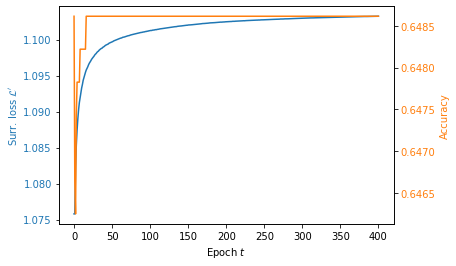

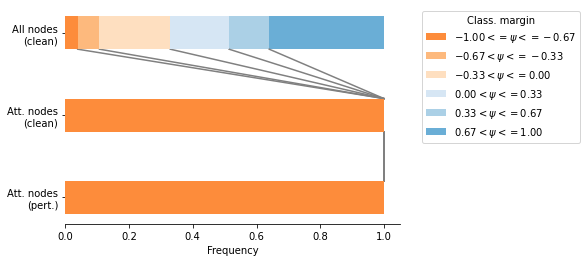

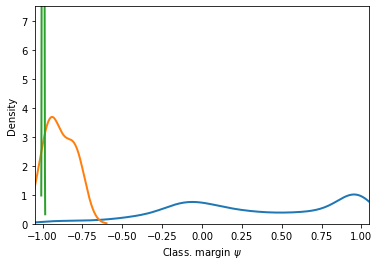

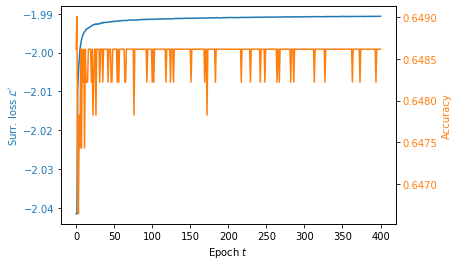

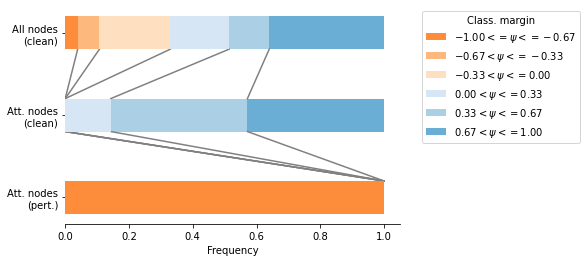

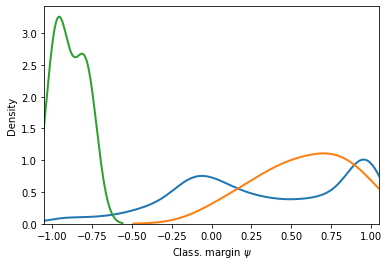

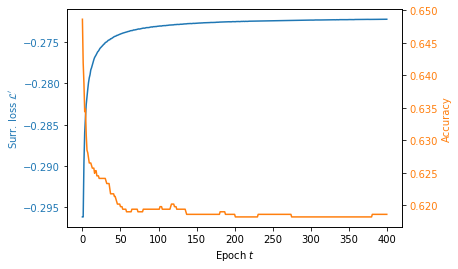

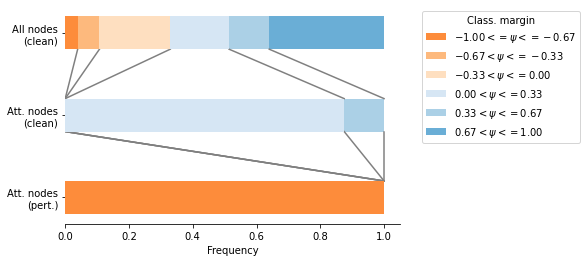

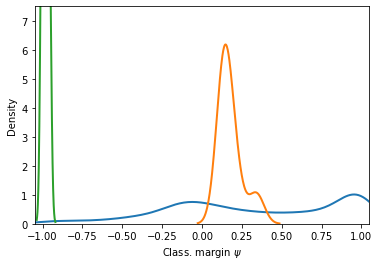

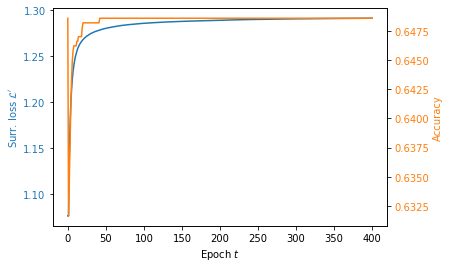

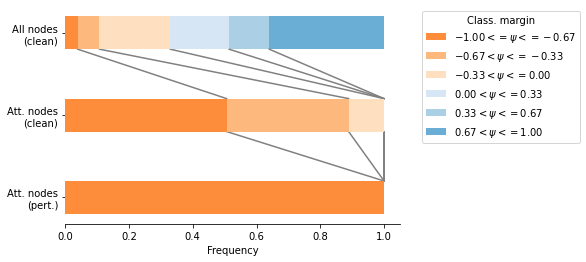

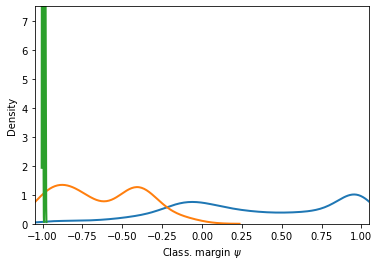

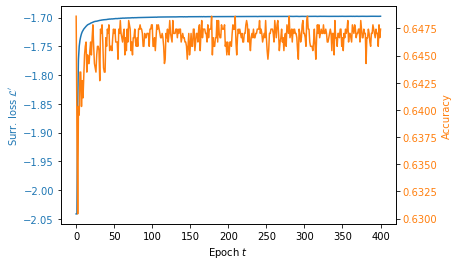

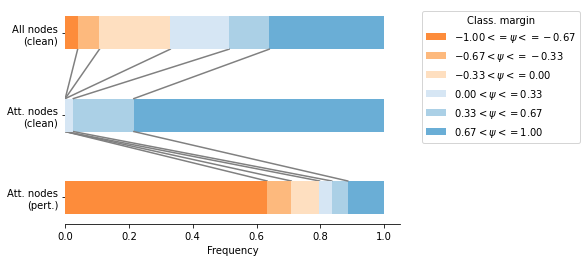

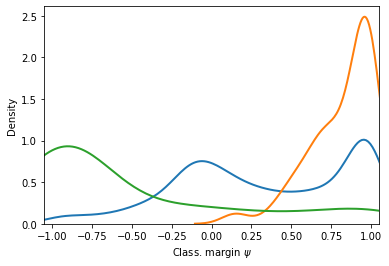

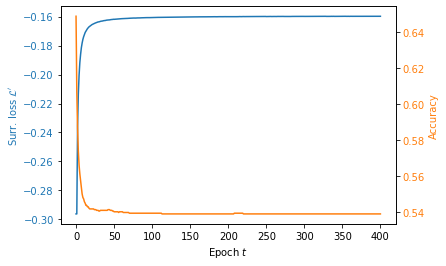

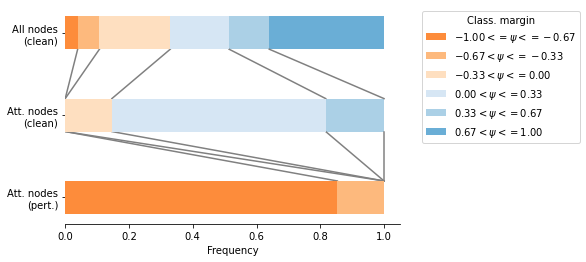

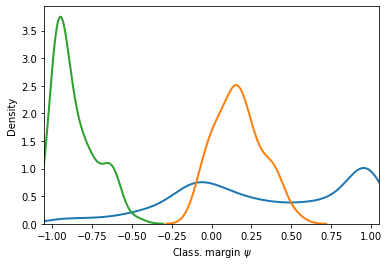

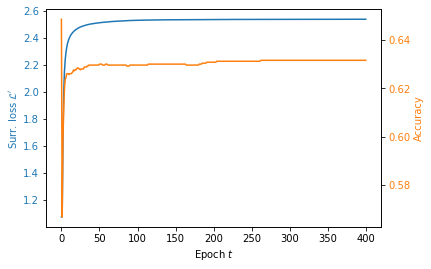

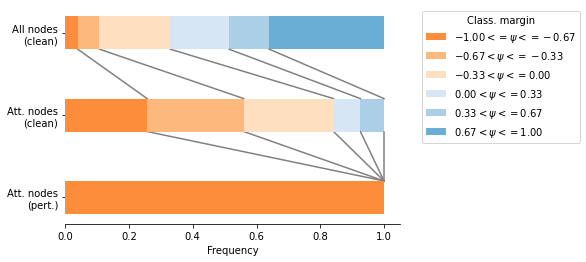

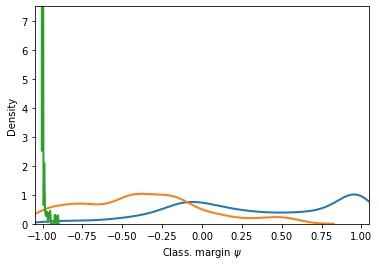

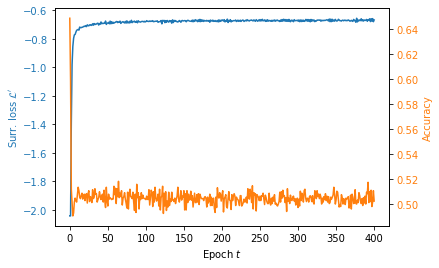

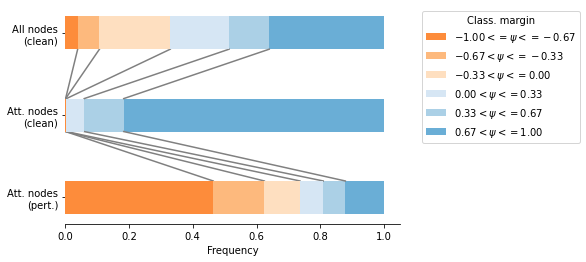

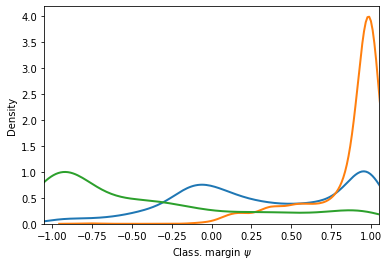

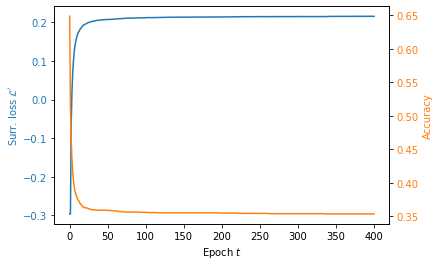

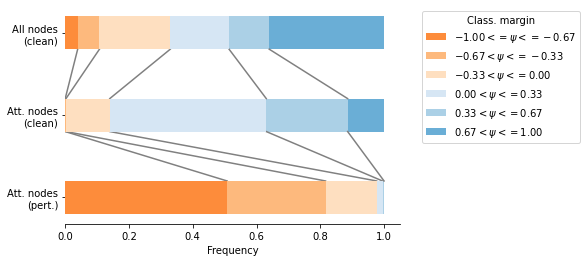

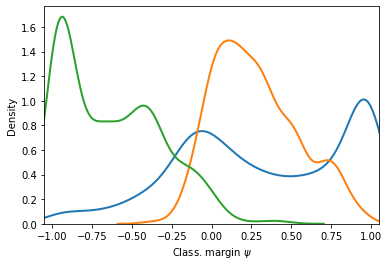

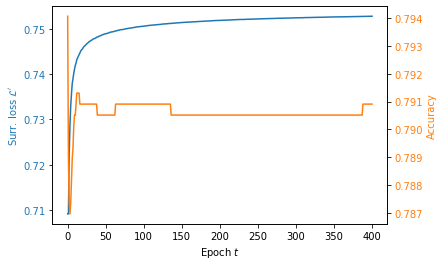

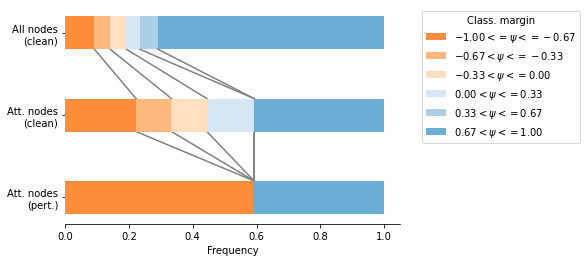

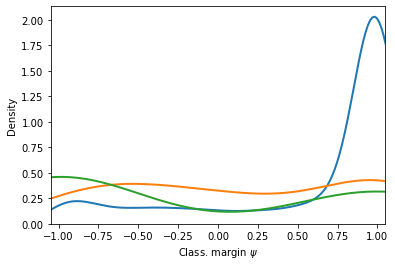

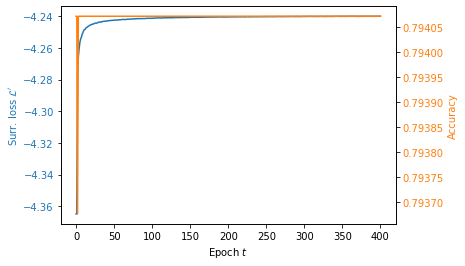

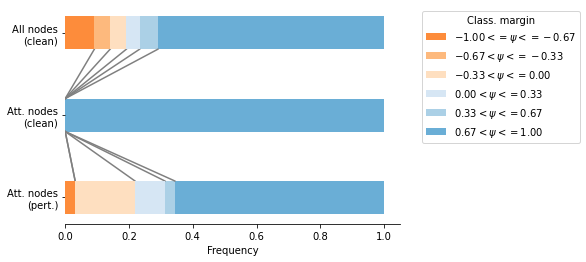

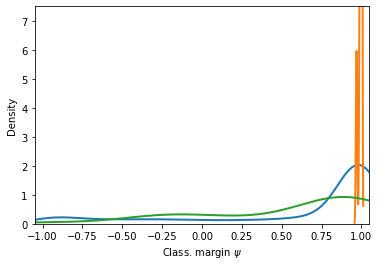

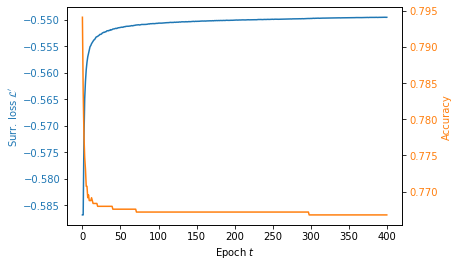

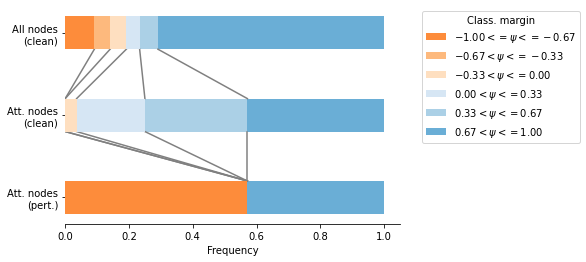

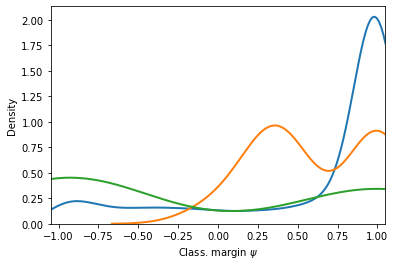

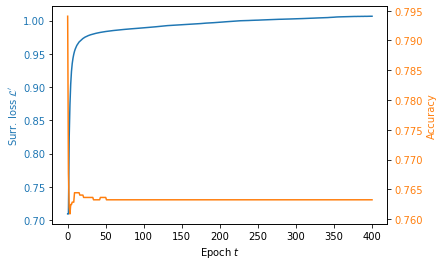

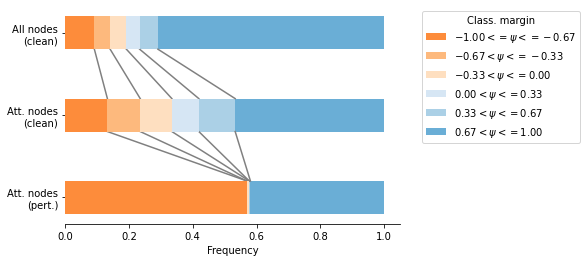

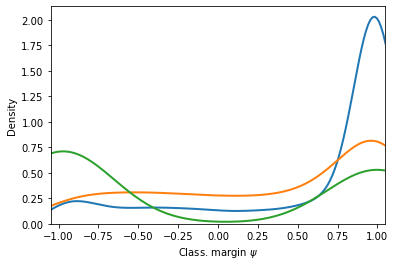

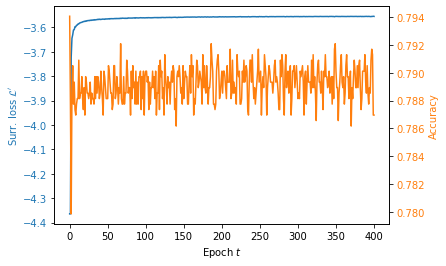

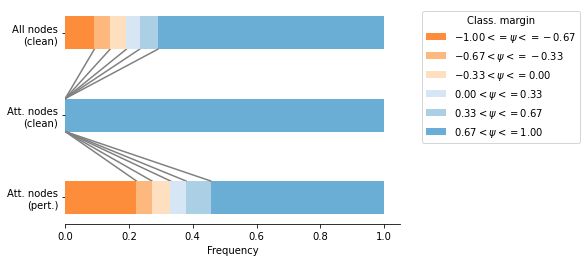

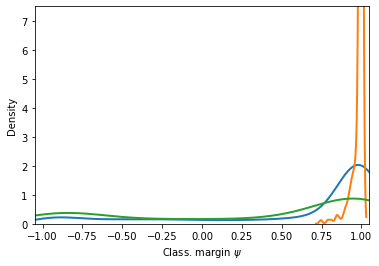

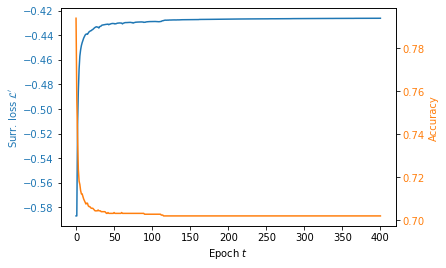

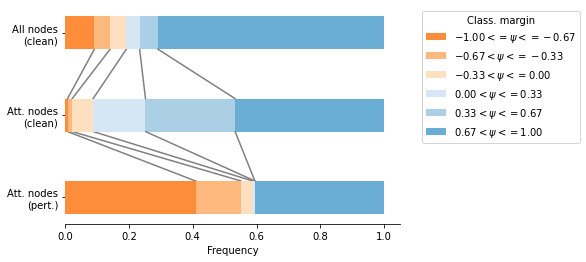

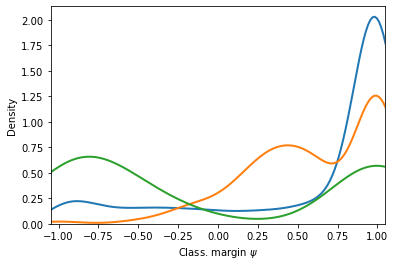

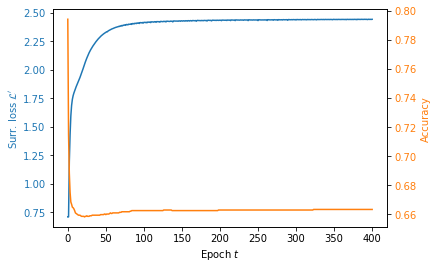

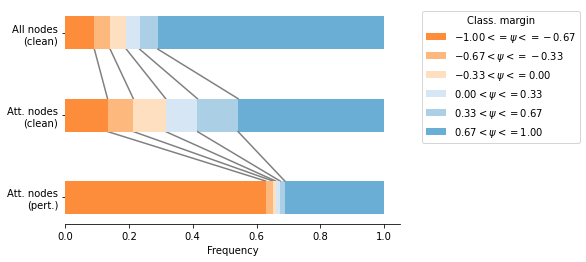

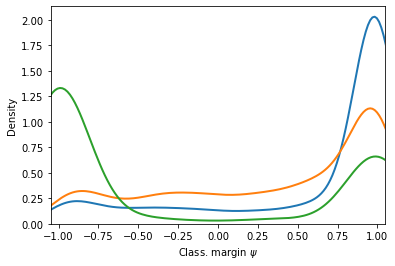

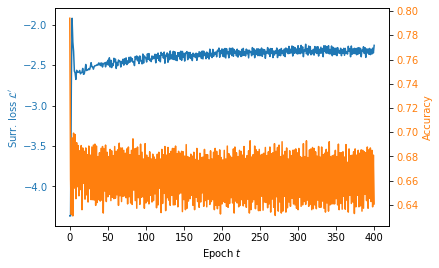

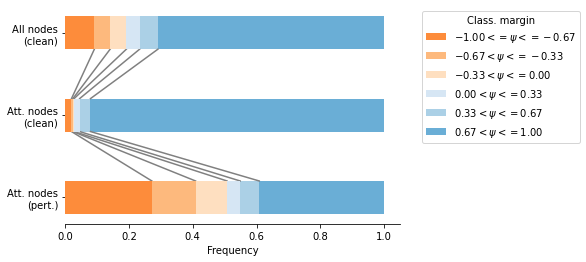

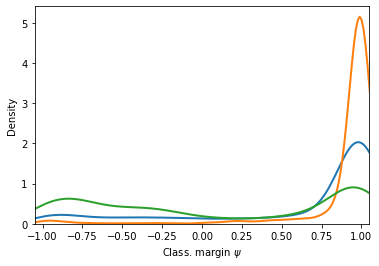

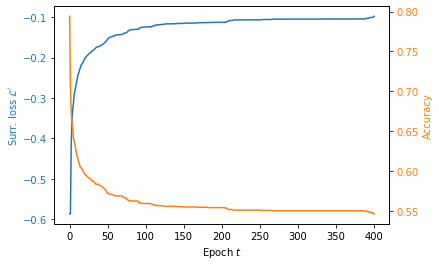

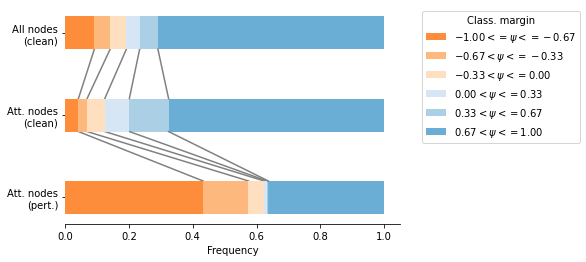

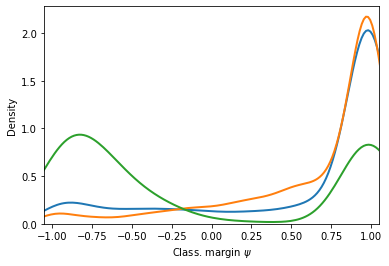

In [7]:
for dataset, search_space_size, victim_params in zip(datasets, search_space_sizes, victim_param_list):
    for make_undirected in [False, True]:
        print(dataset, search_space_size, victim_params, make_undirected)

        graph = prep_graph(dataset, device='cpu', binary_attr=binary_attr, make_undirected=make_undirected,
                           return_original_split=dataset.startswith('ogbn'))
        
        attr, adj, labels = graph[:3]
        if len(graph) == 3:
            idx_train, idx_val, idx_test = split(labels.cpu().numpy())
        else:
            idx_train, idx_val, idx_test = graph[3]['train'], graph[3]['valid'], graph[3]['test']
            
        n_features = attr.shape[1]
        n_classes = int(labels.max() + 1)

        victim_params_current = dict(victim_params)
        if make_undirected == False:
            victim_params['row_norm'] = True
            victim_params_current['n_filters'] = []

        gcn = GCN(n_classes=n_classes, n_features=n_features, **victim_params_current).to(device)
        train(model=gcn, attr=attr.to(device), adj=adj.to(device), labels=labels.to(device),
              idx_train=idx_train, idx_val=idx_val, display_step=display_steps, **train_params)

        gcn.eval()

        with torch.no_grad():
            clean_logits = gcn(attr.to(device), adj.to(device))
        accuracy(clean_logits, labels.to(device), idx_test)
        print(f'Clean accuracy: {accuracy(clean_logits, labels.to(device), idx_test)}')

        for epsilon in epsilons:
            for loss_type in loss_types:
                print(dataset, make_undirected, epsilon, loss_type)
                
                temp_attack_params = dict(attack_params)
                temp_attack_params['loss_type'] = loss_type
                temp_attack_params['epsilon'] = epsilon
                temp_attack_params['search_space_size'] = search_space_size
                
                adversary = create_attack(attack, adj=adj, attr=attr, binary_attr=False, labels=labels, 
                                          make_undirected=make_undirected, model=gcn, idx_attack=idx_test, 
                                          device=device, data_device=device, **temp_attack_params)

                m = adj.nnz()
                torch.manual_seed(seed)
                np.random.seed(seed)

                n_perturbations = int(round(epsilon * m))
                adversary.attack(n_perturbations)
                
                ############## Attack Loss ###############
                
                fig, ax = plt.subplots()

                color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
                ax.set_xlabel('Epoch $t$')
                ax.set_ylabel(r"Surr. loss $\mathcal{L}'$", color=color)
                ax.plot(adversary.attack_statistics['loss'], color=color)
                ax.tick_params(axis='y', labelcolor=color)

                ax = ax.twinx()

                color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
                ax.set_ylabel('Accuracy', color=color)
                ax.plot(adversary.attack_statistics['accuracy'], color=color)
                ax.tick_params(axis='y', labelcolor=color)
                
                plt.gcf().show()
                
                ############################################

                if make_undirected:
                    attcked_edges = adversary.modified_edge_index[
                        :, adversary.modified_edge_weight_diff.round().bool()
                    ].flatten()
                else:
                    attcked_edges = adversary.modified_edge_index[
                        0, adversary.modified_edge_weight_diff.round().bool()
                    ].flatten()
                attcked_edges = attcked_edges[np.isin(attcked_edges.cpu().numpy(), idx_test)]

                with torch.no_grad():
                    attacked_logits = gcn(attr.to(device), adversary.adj_adversary.to(device))
                print(f'Perturbed accuracy: {accuracy(attacked_logits, labels.to(device), idx_test)}')

                sorted_attacked = attacked_logits.argsort(-1).cpu()
                best_non_target_class_attacked = sorted_attacked[sorted_attacked != labels[:, None]].reshape(attacked_logits.size(0), -1)[:, -1]
                margin_attacked = (
                    F.softmax(attacked_logits, dim=-1)[np.arange(attacked_logits.size(0)), labels.long()]
                    - F.softmax(attacked_logits, dim=-1)[np.arange(attacked_logits.size(0)), best_non_target_class_attacked.long()]
                )

                sorted_clean = clean_logits.argsort(-1).cpu()
                best_non_target_class = sorted_clean[sorted_clean != labels[:, None]].reshape(clean_logits.size(0), -1)[:, -1]
                margin = (
                    F.softmax(clean_logits, dim=-1)[np.arange(clean_logits.size(0)), labels.long()]
                    - F.softmax(clean_logits, dim=-1)[np.arange(clean_logits.size(0)), best_non_target_class.long()]
                )

                freq_all_clean, borders = np.histogram(margin.cpu(), bins=bins, range=(-1,1), density=True)
                freq_attacked_clean, _ = np.histogram(margin[attcked_edges].cpu(), bins=bins, range=(-1,1), density=True)
                freq_attacked_pert, _ = np.histogram(margin_attacked[attcked_edges].cpu(), bins=bins, range=(-1,1), density=True)

                freq_all_clean = 2 / bins * np.cumsum(freq_all_clean)
                freq_attacked_clean = 2 / bins * np.cumsum(freq_attacked_clean)
                freq_attacked_pert = 2 / bins * np.cumsum(freq_attacked_pert)

                ############## Bar Plot ###############
                
                fig, ax = plt.subplots()

                for i, (el_0, el_1, el_2, color) in enumerate(zip(freq_all_clean, freq_attacked_clean, freq_attacked_pert, colors)):
                    if i != 0:
                        sep = '<'
                    else:
                        sep = '<='
                    plt.barh([x_0, x_1, x_2],
                             (el_0, el_1, el_2), 
                             bar_width,
                             color=color,
                             zorder=bins - i,
                             label=f'${borders[i]:.2f} {sep} \psi <= {borders[i + 1]:.2f}$')
                    if i < bins-1:
                        plt.plot((el_0, el_1), [x_0 - bar_width / 2, x_1 + bar_width / 2], color='grey', label='_nolegend_')
                        plt.plot((el_1, el_2), [x_1 - bar_width / 2, x_2 + bar_width / 2], color='grey', label='_nolegend_')

                plt.yticks([x_0, x_1, x_2], ['All nodes\n(clean)', 'Att. nodes\n(clean)', 'Att. nodes\n(pert.)'])

                plt.grid(False)

                ax.spines['right'].set_visible(False)
                ax.spines['left'].set_visible(False)
                ax.spines['top'].set_visible(False)

                plt.xlabel('Frequency')
                plt.legend(bbox_to_anchor=(1.05, 1), title=r'Class. margin', loc='upper left')

                plt.gcf().show()
                
                ############################################
                
                ############## KDE Plot ###############
                
                fig, ax = plt.subplots()

                kde1 = sns.kdeplot(margin.cpu().numpy(), ax=ax, label='Test nodes (clean)', linewidth=2)
                kde2 = sns.kdeplot(margin[attcked_edges].cpu().numpy(), ax=ax, label='Att. nodes (clean)', linewidth=2)
                kde3 = sns.kdeplot(margin_attacked[attcked_edges].cpu().numpy(), ax=ax, label='Att. nodes (pert.)', linewidth=2) #, 
                                   #color=kde2.lines[-1].get_color(), linestyle='--') # FOR CAMERA READY


                plt.xlim(-1.05, 1.05)
                plt.xlabel('Class. margin $\psi$')
                
                if ax.get_ylim()[1] > y_kde_max:
                    ax.set_ylim(0, y_kde_max)
                
                ############################################